In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
import matplotlib.pyplot as plt

In [2]:

print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
# Load your CSV file containing image names, features, and labels
data = pd.read_csv('../output/training_data/train.csv')

In [5]:
def remove_white_images_without_neigbour(row):
    if (row['neighbours'] == 0) & (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True
    
def remove_white_images(row):
    if (int(row['len_of_boundry_inv']) == 0):
        return False
    else:
        return True

In [6]:
data = data[data.apply(remove_white_images, axis=1)]
data.shape

(3856, 8)

In [7]:
# Load and preprocess black and white images
image_data = []
for image_file in data['name']:
    image = load_img('../output/tiles/' + image_file, color_mode='grayscale', target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0  # Normalize pixel values
    image_data.append(image)

image_data = np.array(image_data)

In [8]:
# Load numerical features and output
features = data[['len_of_boundry_inv', 'disjoint_image', 'neighbours']].values
#features = data[['len_of_boundry_inv', 'disjoint_image']].values
labels = data['num_triangles'].values
labels = labels.astype(float)


In [16]:
from sklearn.preprocessing import RobustScaler

In [17]:
robust_scaler = RobustScaler()
features = robust_scaler.fit_transform(features)

In [18]:
random_state = 0

# Split the data into training, validation, and test sets for images
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

# Split the data into training, validation, and test sets for features
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=random_state)
features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=random_state)

In [21]:
def printshape(val):
    for v in val:
        print(v.shape)

In [ ]:
printshape([X_train, X_test, X_val])
printshape([y_train, y_test, y_val])
printshape([features_train, features_test, features_val])
printshape([labels_train, labels_test, labels_val])

In [8]:
# Define the input layers
image_input = Input(shape=(224, 224, 1))
feature_input = Input(shape=(3,))

In [10]:
noc = features.shape[1]

In [27]:
def create_model():
    # Define the input layers
    image_input = Input(shape=(224, 224, 1))
    feature_input = Input(shape=(noc,))

    # CNN for processing images
    conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(maxpool2)

    # Dense network for processing features
    dense1 = Dense(32, activation='relu')(feature_input)

    # Combine the two networks
    merged = Concatenate()([flatten, dense1])

    # Fully connected layers
    fc1 = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='linear')(fc1)

    # Create the model
    model = keras.Model(inputs=[image_input, feature_input], outputs=output)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model


In [12]:
def showDetails(history):
    # Access training history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    training_accuracy = history.history['mean_absolute_error']
    validation_accuracy = history.history['val_mean_absolute_error']

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training MAE')
    plt.plot(validation_accuracy, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.title('Training and Validation Mean Absolute Error')

    plt.tight_layout()
    plt.show()

In [28]:
model = create_model()

In [ ]:
model.summary()

In [29]:
# Train the model
history = model.fit([X_train, features_train], y_train, validation_data=([X_val, features_val], y_val), epochs=10)

Epoch 1/10
78/78 [==============================] - 3s 27ms/step - loss: 29605.6973 - mean_absolute_error: 126.7373 - val_loss: 24938.5000 - val_mean_absolute_error: 111.8065
Epoch 2/10
78/78 [==============================] - 2s 21ms/step - loss: 21781.4219 - mean_absolute_error: 105.7910 - val_loss: 24522.8379 - val_mean_absolute_error: 114.8596
Epoch 3/10
78/78 [==============================] - 2s 21ms/step - loss: 20228.0371 - mean_absolute_error: 99.2950 - val_loss: 28519.6426 - val_mean_absolute_error: 133.9720
Epoch 4/10
78/78 [==============================] - 2s 21ms/step - loss: 18323.4199 - mean_absolute_error: 93.0891 - val_loss: 21973.1191 - val_mean_absolute_error: 96.3915
Epoch 5/10
78/78 [==============================] - 2s 21ms/step - loss: 16321.9258 - mean_absolute_error: 85.5719 - val_loss: 22499.2852 - val_mean_absolute_error: 95.2767
Epoch 6/10
78/78 [==============================] - 2s 21ms/step - loss: 15046.2588 - mean_absolute_error: 82.2802 - val_loss: 227

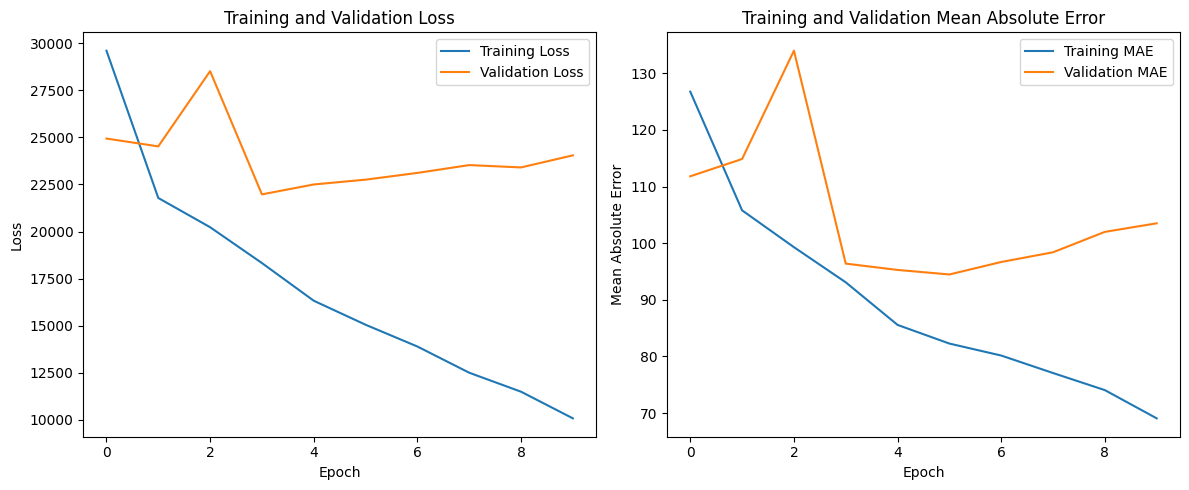

In [30]:
showDetails(history)

In [ ]:
# Without neighbour
showDetails(history)

In [22]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate([X_test, features_test], y_test)
# Print the test loss and MAE
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


25/25 [==============================] - 0s 9ms/step - loss: 19870.2461 - mean_absolute_error: 98.2608
Test Loss: 19870.24609375
Test MAE: 98.2608413696289


In [ ]:
# with neighbours
showDetails(history)

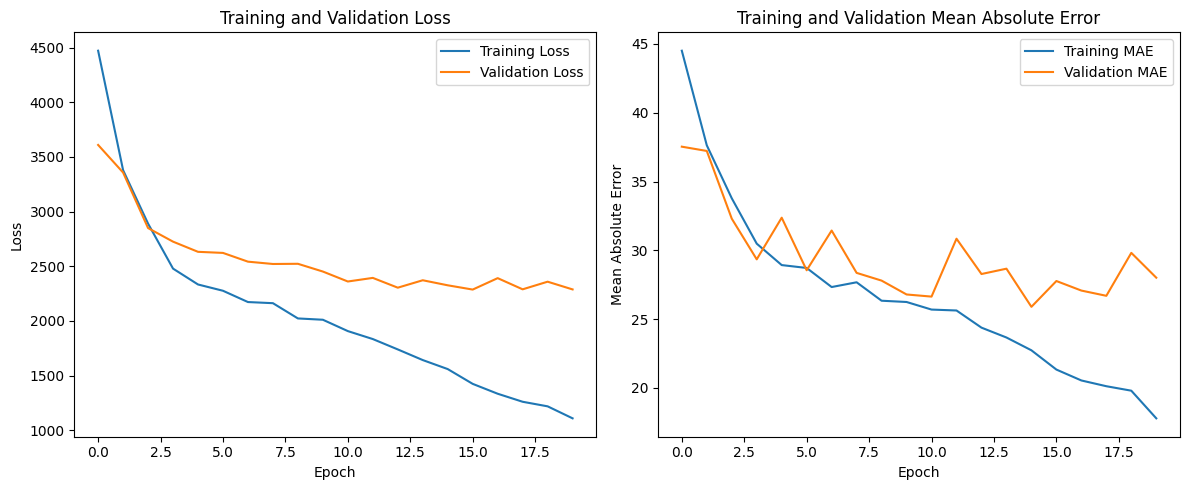

In [14]:
# with neighbours
showDetails(history)

In [15]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate([X_test, features_test], y_test)
# Print the test loss and MAE
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

48/48 [==============================] - 1s 10ms/step - loss: 2067.4729 - mean_absolute_error: 28.3986
Test Loss: 2067.472900390625
Test MAE: 28.398569107055664


In [14]:
from keras.utils import plot_model, model_to_dot

# Assuming 'model' is your neural network model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Assuming 'model' is your neural network model
dot = model_to_dot(model, show_shapes=True, show_layer_names=True)

# Save the DOT file
with open("model.dot", "w") as dot_file:
    dot_file.write(dot.to_string())


In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [21]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [12]:
name = 'Micro_coupler_0_1.png'
file = name.split('.')[0]
rowcol = file.rsplit('_', 2)
row = int(rowcol[1])
col = rowcol[2]
print(row,col)
filename = rowcol[0]
filename
type(row)

0 1


int

In [10]:
cols = ['col1', 'col2']
features_df = pd.DataFrame()

features_df = features_df._append(pd.DataFrame(
    {
    'col1':[1,2,3],
    'col2':[4,5,6]
}
),ignore_index=True)



features_df

,col1,col2
0,1,4
1,2,5
2,3,6
